# DSIP Assignment (third part)
Giulia Benvenuto S4678610

# Image processing basics
## Generation of the image
- Generate a synthetic image I of size $200x200$ with a black background containing 3 squares of side $10$, $30$, $50$ pixels the position of which (I’m referring to both the row and column components of the top-left vertex) is sampled uniformly in the range $[0,140]$. Each of the squares will have a constant brightness, sampled uniformly in the range $[50,255]$.

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.draw
import scipy
import cv2
plt.rcParams["figure.figsize"] = (6,6)

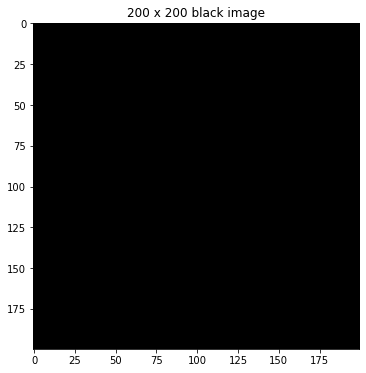

In [36]:
# Create the image "I" of size 200x200 with black background
I = np.zeros((200, 200), dtype=np.uint8)

plt.imshow(I, cmap='gray')
plt.title('200 x 200 black image')
plt.show()

In [37]:
# Sample the position (both row and column) of the top-left vertex for each square
v1_x, v1_y = np.random.randint(0, 140, 2)
v2_x, v2_y = np.random.randint(0, 140, 2)
v3_x, v3_y = np.random.randint(0, 140, 2)

# Sample the constant brightness for each square
brightness1 = np.random.randint(50, 255)
brightness2 = np.random.randint(50, 255)
brightness3 = np.random.randint(50, 255)

## Draw the rectangles on the image
We need to consider that the origin of the image is in the left-top corner so in order to draw the rectangles, starting from the sampled left-top coordinates of their corners, we need to increase both on x and y axis by 10, 30 or 50 pixels.

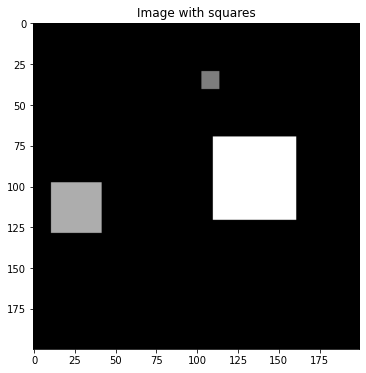

In [38]:
# Draw 10x10 square on the image
row, column = skimage.draw.rectangle((v1_x, v1_y), ((v1_x + 10), (v1_y + 10)))
I[row, column] = brightness1

# Draw 30x30 square on the image
row, column = skimage.draw.rectangle((v2_x, v2_y), ((v2_x + 30), (v2_y + 30)))
I[row, column] = brightness2

# Draw 50x50 square on the image
row, column = skimage.draw.rectangle((v3_x, v3_y), ((v3_x + 50), (v3_y + 50)))
I[row, column] = brightness3


plt.imshow(I, cmap='gray')
plt.title('Image with squares')
plt.show()

## Rotation of the image
- Rotate the image around its center (that is the point of coordinates $(100,100)$) of an angle $\theta$ sampled uniformly in the range $[10, 80] \rightarrow I_r$.


In [39]:
# Sample the angle of rotation theta 
theta = np.random.uniform(10, 80)
center = (100, 100)

print("Angle of rotation theta: %f" %theta)

Angle of rotation theta: 59.013966


I used the rotate function provided by the skimage library. But to implement the rotation about the origin from scratch we need to:
- Translate the image so that its center is at the origin (0, 0). This can be done by subtracting the x and y coordinates of the center from each pixel's coordinates.
- Perform the rotation using a 2D rotation matrix, which is a linear transformation that rotates a vector in a 2D space. The most common rotation matrix is:
$\begin{bmatrix}
    \cos\theta & -\sin\theta\\
    \sin\theta & \cos\theta\\
\end{bmatrix}$
where theta is the angle of rotation.
- Translate the image back to its original position by adding the x and y coordinates of the center to each pixel's coordinates.



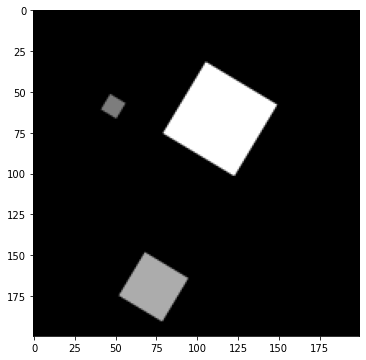

In [40]:
# Rotation of the image about its center using skimage library
from skimage.transform import rotate

I_r = rotate(I, theta)

# Normalizes data in range 0 - 255:
I_r = I_r / I_r.max() * 255
# Cast to uint8:
I_r = np.clip(I_r, 0, 255).astype(np.uint8)

plt.imshow(I_r, cmap='gray')
plt.show()

# 2D Discrete Fourier Transform
- Compute the DFT of the two images, I and Ir, and visualize them, in the appropriate way (meaning, using the appropriate shifting) side by side.

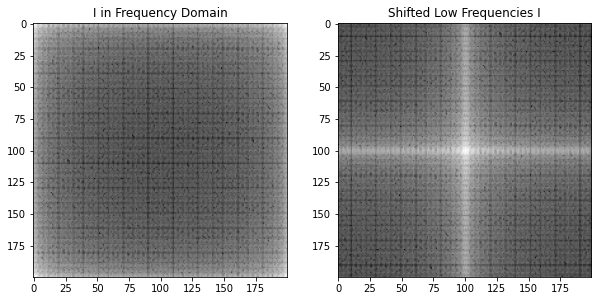

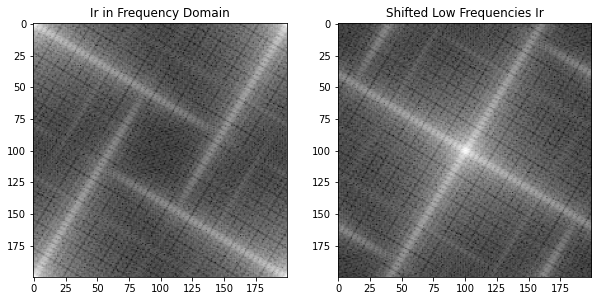

In [41]:
# 2-dimensional fourier transform:
I_dft = np.fft.fft2(I)
Ir_dft = np.fft.fft2(I_r)


# Shift the zero-frequency component to the center of the spectrum.
I_dft_shifted = np.fft.fftshift(I_dft)
Ir_dft_shifted = np.fft.fftshift(Ir_dft)


plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(np.log1p(np.abs(I_dft)), cmap='gray')
plt.title('I in Frequency Domain')

plt.subplot(122)
plt.imshow(np.log1p(np.abs(I_dft_shifted)), cmap='gray')
plt.title('Shifted Low Frequencies I')
plt.show()


plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(np.log1p(np.abs(Ir_dft)), cmap='gray')
plt.title('Ir in Frequency Domain')

plt.subplot(122)
plt.imshow(np.log1p(np.abs(Ir_dft_shifted)), cmap='gray')
plt.title('Shifted Low Frequencies Ir')
plt.show()

plt.show()

The 2D Discrete Fourier Transform computes the spectrum of a 2D discrete signal (image).

As for the 1D discretized signals case, in which the specturm is composed by an infinite amount of replicas of the signal's Fourier Transform, here in the 2D case it's the same. The spectrum obtained from the 2D discretized image will repeat itself endlessly in both horizontal and vertical directions with a periodicity. In order to visualize one replica of the DFT we need an appropriate frequency shift that will take the DC component (zero-frequency component) at the center of the spectrum, so I used the function ${\tt np.fft.fftshift()}$.

We can also note that the spectrum is sensitive to the rotation. The image $I_r$ is rotated about an angle $\theta$ thus also its spectrum will be rotated by the same angle. 

# Image filtering
- Implement high pass / enhancement filtering procedures, in space and in frequencies. Make appropriate design choices in the two cases (that is, select appropriate filters for Fourier and for space filtering).
- Use the results from the step above to obtain a coarse edge map associated with images $I$ and $Ir$.

## High pass filter / Enhancement filter 
This type of filters let pass only the high frequencies, dropping the low ones. Generally in images the fine details in an image are associated with the high frequency components, this is why the high pass filters are used to enhance details and highlight intensity transitions in the images. 

We also need to remember that high pass filters are the reverse of low pass filters: $H_{hp}(u,v) = 1 - H_{lp}(u,v)$

## Space filtering
The space filtering process consists in two steps:
- Select the appropriate filter $h(x,y)$.
- Convolve the original image in the space domain $f(x,y)$ with the filter $h(x,y)$. This step is possible through the 2D discrete convolution  $g[x,y] = (f \ast k)[x,y]$. The result is the filtered image $g$.

### Laplacian filter
As space filter I decided to implement the Laplacian Filter. The Laplacian in general is a measure of the second derivative of an image, using it we can detect the zero-crossings which are good indicators of sharp variations in the image. 

The Laplacian is defined as: $\nabla^{2}f =\frac{\partial^2 f}{\partial x^2}+\frac{\partial^2 f}{\partial y^2}$, it is the sum of derivatives and so it is linear. Since it's linear it can be represented through an appropriate kernel. 

The convolution between the image and the kernel is handeled by the ${\tt cv2.filter2D()}$ function.

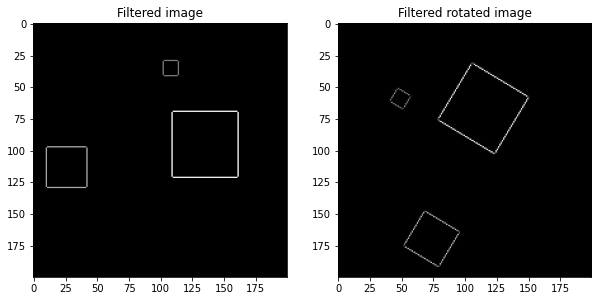

In [42]:
kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

I_space_filter = cv2.filter2D(I, -1, kernel)
Ir_space_filter = cv2.filter2D(I_r, -1, kernel)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(I_space_filter, cmap='gray')
plt.title('Filtered image')
plt.subplot(122)
plt.imshow(Ir_space_filter, cmap='gray')
plt.title('Filtered rotated image')
plt.show()

This Laplacian filter could be interpreted ad an edge detector. 

## Fourier Filtering
The process to filter an image in the frequency domain is the following one:

**1.** Transform the image $f(x,y)$ into frequency domain using the Fourier Transform $F(u,v)$

**2.** Multiply the Fourier Transform of the image with the filter $H(u,v)$

**3.** Take the inverse Fourier Transform of $G(u,v)$ to obtain $g(x,y)$

where: 
- $f(x,y)$ image in spatial domain
- $F(u,v)$ image in frequency domain
- $H(u,v)$ filter
- $G(u,v)$ filtered image in frequency domain
- $g(x,y)$ filtered image in spatial domain

At first I implemented an **Ideal low pass filter** $H(u,v)$, then I computed the correspondent **Ideal high pass filter** as $H(u,v) = 1 - H(u,v)$.

### Ideal low pass filter
The ideal low pass filter is defined as:

<center>\[  H(u,v) = 
    \left\{
        \begin{array}{ll}
          1 & D(u,v)\leq D_0 \\
          0 & D(u,v) > D_0 \\
        \end{array} 
    \right. \]
</center>

and 

<center>
    $D(u,v) = \sqrt{(u - R/2)^2 + (v - C/2)^2}$
</center>
$D_0$ is the cut off frequency
$R, C$ is the size of the image (rows, columns)

### Ideal low pass filter implementation

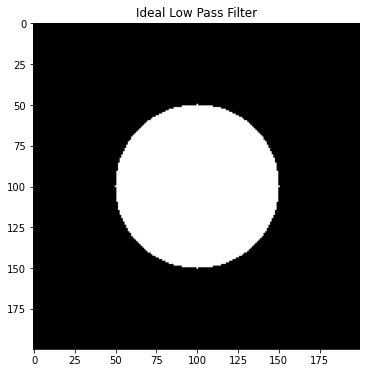

In [43]:
R, C = I.shape
H = np.zeros((R,C), dtype = np.float32)
D0 = 50

for u in range(R):
    for v in range(C):
        D = np.sqrt((u-R/2)**2 + (v-C/2)**2)
        if D <= D0:
            H[u,v] = 1
        else:
            H[u,v] = 0

plt.imshow(H, cmap = 'gray')
plt.title('Ideal Low Pass Filter')
plt.show()

**Observations:**
- If $D_0$ is a small value, such as $D_0 = 10$ the filter will discard most of the high frequencies and let pass only a small amount of frequencies and so the image will be very smoothed.

- If $D_0$ is a big value, such as $D_0 = 500$ the filter will discard a small amount of frequencies and let pass most of them, so the image will be almos perfectly reconstructed and the action of the filter will be barely visible.

### Ideal high pass filter
It is defined as $H(u,v) = 1 - H(u,v)$.

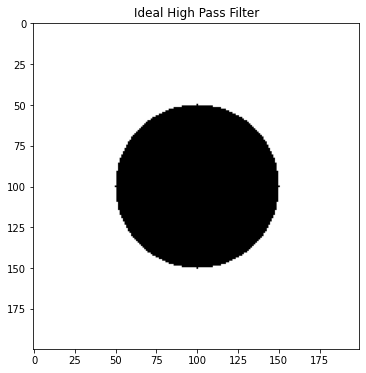

In [44]:
H = 1 - H

plt.imshow(H, cmap = 'gray')
plt.title('Ideal High Pass Filter')
plt.show()

### Filtering the image ######

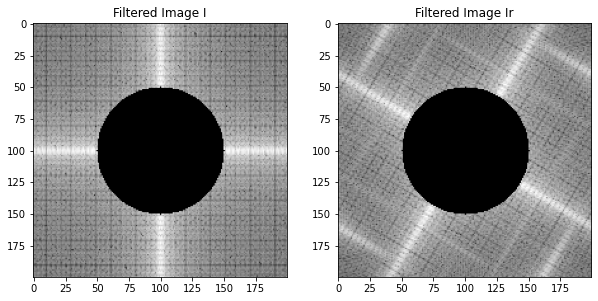

In [45]:
# To apply the filter multiply the shifted version of the F.T. with the filter

# Original Image I
G_I_shift = I_dft_shifted * H

# Rotated Image Ir
G_Ir_shift = Ir_dft_shifted * H


plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(np.log1p(np.abs(G_I_shift)), cmap='gray')
plt.title('Filtered Image I')

plt.subplot(122)
plt.imshow(np.log1p(np.abs(G_Ir_shift)), cmap='gray')
plt.title('Filtered Image Ir')
plt.show()

### Shift back the frequencies 

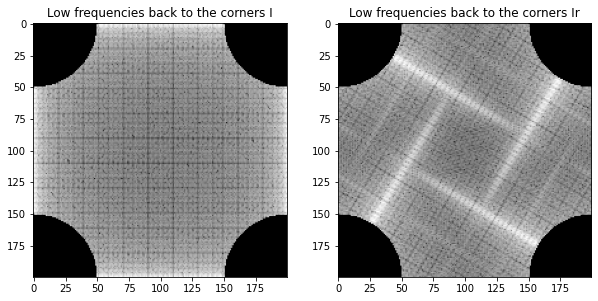

In [46]:
G_I = np.fft.ifftshift(G_I_shift)

G_Ir = np.fft.ifftshift(G_Ir_shift)


plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(np.log1p(np.abs(G_I)), cmap='gray')
plt.title('Low frequencies back to the corners I')

plt.subplot(122)
plt.imshow(np.log1p(np.abs(G_Ir)), cmap='gray')
plt.title('Low frequencies back to the corners Ir')
plt.show()

### Inverse Fourier Transform

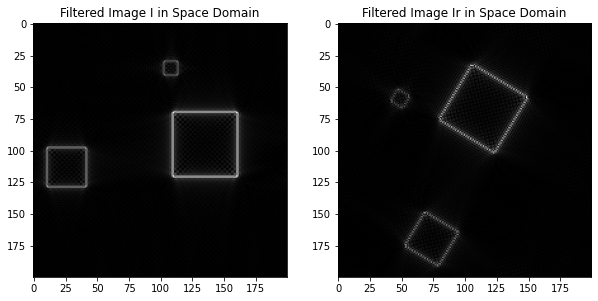

In [47]:
g_I = np.abs(np.fft.ifft2(G_I))
g_Ir = np.abs(np.fft.ifft2(G_Ir))


plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(g_I, cmap='gray')
plt.title('Filtered Image I in Space Domain')

plt.subplot(122)
plt.imshow(g_Ir, cmap='gray')
plt.title('Filtered Image Ir in Space Domain')
plt.show()

### Gaussian high pass filter
In order to implement a Gaussian high pass filter, at first, I implemented a Gaussian low pass filter $H(u,v)$ and then I obtained the correspondent high one as $H(u,v) = 1 - H(u,v)$.

Where the Gaussin low pass filter is defined as:
<center>
    $H_{low}(u,v) = e^{- \frac{D^{2} (u,v)}{2 D_0^{2}}}$
</center>

and so the Gaussian high pass filter will be:
<center>
    $H_{high}(u,v) = 1 - H_{low}(u,v) = 1 - e^{- \frac{D^{2} (u,v)}{2 D_0^{2}}}$
</center>

### Gaussian low pass filter implementation

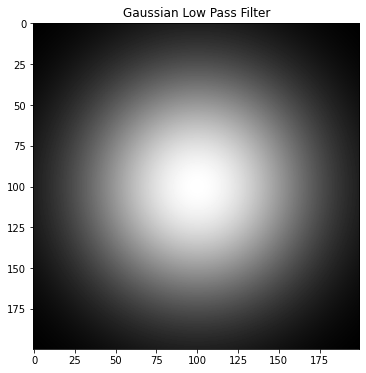

In [48]:
R, C = I.shape
H = np.zeros((R,C), dtype = np.float32)
D0 = 50

for u in range(R):
    for v in range(C):
        D = np.sqrt((u-R/2)**2 + (v-C/2)**2)
        H[u,v] = np.exp(-((D**2)/(2*(D0**2))))

plt.imshow(H, cmap = 'gray')
plt.title('Gaussian Low Pass Filter')
plt.show()

### Gaussian high pass filter implementation

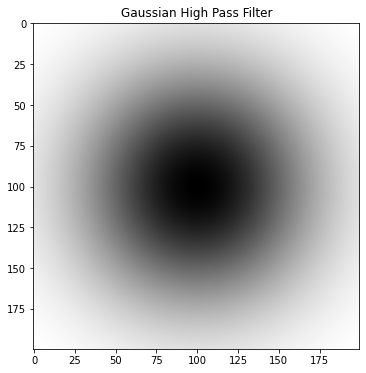

In [49]:
H = 1 - H

plt.imshow(H, cmap = 'gray')
plt.title('Gaussian High Pass Filter')
plt.show()

### Filtering the image

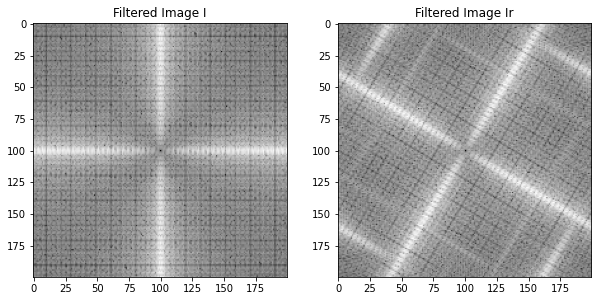

In [50]:
# To apply the filter multiply the shifted version of the F.T. with the filter

# Original Image I
G_I_shift = I_dft_shifted * H

# Rotated Image Ir
G_Ir_shift = Ir_dft_shifted * H


plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(np.log1p(np.abs(G_I_shift)), cmap='gray')
plt.title('Filtered Image I')

plt.subplot(122)
plt.imshow(np.log1p(np.abs(G_Ir_shift)), cmap='gray')
plt.title('Filtered Image Ir')
plt.show()

### Shift back the frequencies

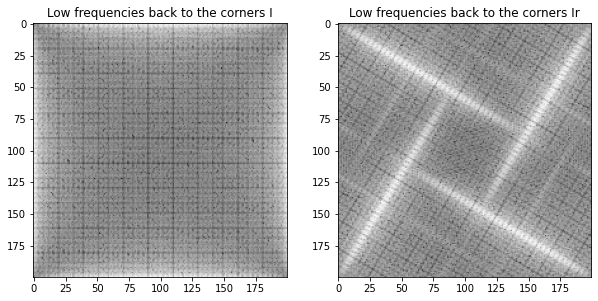

In [51]:
# The low frequency are positioned back to the corner
G_I = np.fft.ifftshift(G_I_shift)

G_Ir = np.fft.ifftshift(G_Ir_shift)


plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(np.log1p(np.abs(G_I)), cmap='gray')
plt.title('Low frequencies back to the corners I')

plt.subplot(122)
plt.imshow(np.log1p(np.abs(G_Ir)), cmap='gray')
plt.title('Low frequencies back to the corners Ir')
plt.show()

### Inverse Fourier Transform

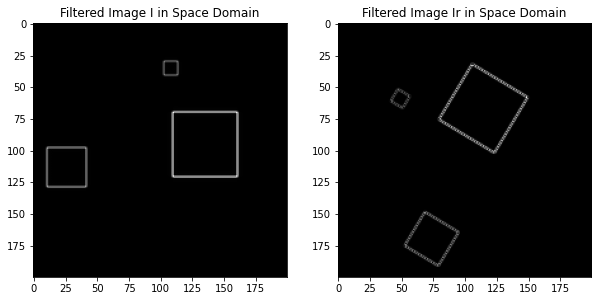

In [52]:
g_I = np.abs(np.fft.ifft2(G_I))

g_Ir = np.abs(np.fft.ifft2(G_Ir))


plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(g_I, cmap='gray')
plt.title('Filtered Image I in Space Domain')

plt.subplot(122)
plt.imshow(g_Ir, cmap='gray')
plt.title('Filtered Image Ir in Space Domain')
plt.show()

## Coarse Edge Map
All the results I obtained by applying the high pass filter to the images $I$ and $I_r$ are coarse edge maps. This is because in general a *coarse edge map* is an image in which there is a simplified representation of the edges in it. It is a binary image where white pixels indicate the presence of an edge and black pixels indicate the absence of an edge. The goal of a coarse edge map is to reduce the complexity of an image while preserving the important features such as edges and corners. The result is a simplified version of the original image that can be used for further image processing tasks.

A coarse edge map is based on the concept of *Edge detection* which it has as its goal to highlight sharp changes in image brightness and to capture important events and changes of intensity in the images. A way to implement the edge detection is using enhancement filres / high pass filters, as I done above. 

Thus all the result obtained above with the implementation and application of the high pass filters above are valid examples of coarse edge maps. Observing them we can note that  they higlight the edges of the squares in the image because they're the only feature in the image and the only reason for which we have a change of intensity since their color is different from the background color. We can also note that:
- If the color of a square tends to be white (light shadow of gray), the contrast with the background will be accentuated and so the edges will be more visible and in the coarse edge map they will be marked with a very marked line. 
- If the color of the square is similar to the color of the backgrond in the coarse edge map the line that indicates the edges will be less visible because less marked. 

There are some filters more specific which implements a coarse edge map and the edge detection in a more efficient way, one example is the following *Sobel Filter*.

### Sobel filter 
The *Sobel filter* is an implementation for edge detection based on the computation of the gradient of the image. The Sobel operator is based on convolving the image with a small integer-valued filter both in the horizontal and vertical directions.

The sobel edge technique is implemented by computing the convolution of the image with two different filters that enhance the horizontal edges and the vertical edges. 

The filter for the horizontal edges is:
<center>
    $sobel_x = \begin{bmatrix}
        -1 & -2 & -1\\
        0 & 0 & 0\\
        1 & 2 & 1
        \end{bmatrix}$
</center>
The filter for the vertical edges is the transpose of the previous one:
<center>
    $sobel_y = (sobel_{x})^\intercal = \begin{bmatrix}
        -1 & 0 & 1\\
        -2 & 0 & 2\\
        -1 & 0 & 1
        \end{bmatrix}$
</center>
Then these two results are combined as following:
<center>
    $edges = \sqrt{(edge_x)^2 + (edge_y)^2}$
</center>

This means that the Sobel Filter is a "separable kernel" and so, instead of using a single 2D convolution operation (which costs $O(K^2)$ because K × K is the size of the kernel mask) we use two consecutive 1D fltering operations (which may be more effcient $O(2K)$) and then combine the results usign the relation above.


### Sobel filter with the library cv2

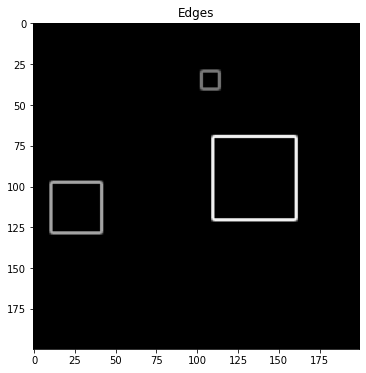

In [53]:
edge_x = cv2.Sobel(I, cv2.CV_64F, 1, 0, ksize=3)
edge_y = cv2.Sobel(I, cv2.CV_64F, 0, 1, ksize=3)
edges = np.sqrt((edge_x**2) + (edge_y**2))

plt.imshow(edges, cmap='gray')
plt.title('Edges')
plt.show()

### Sobel filter from scratch

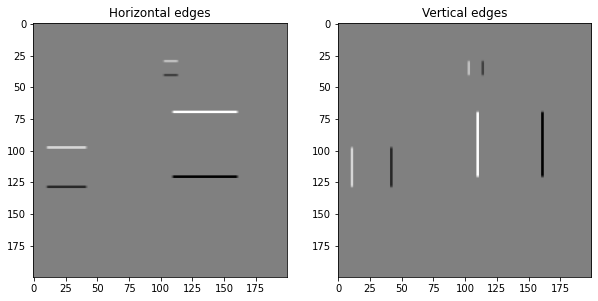

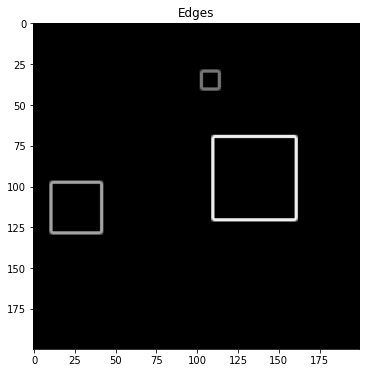

In [54]:
sobel_x = np.array([[-1, -2, -1], 
                    [0, 0, 0],
                    [1, 2, 1]])
sobel_y = np.array([[-1, 0, 1], 
                    [-2, 0, 2],
                    [-1, 0, 1]])

# Convolve the image I with the two filters:
edge_x = cv2.filter2D(I, cv2.CV_64F, sobel_x)
edge_y = cv2.filter2D(I, cv2.CV_64F, sobel_y)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(edge_x, cmap='gray')
plt.title('Horizontal edges')

plt.subplot(122)
plt.imshow(edge_y, cmap='gray')
plt.title('Vertical edges')
plt.show()

# Combine the horizontal edges on the vertical edges:
edges = np.sqrt((edge_x)**2 + (edge_y)**2)

edges = edges / edges.max() * 255
edges = np.clip(edges, 0, 255).astype(np.uint8)

plt.imshow(edges, cmap='gray')
plt.title('Edges')
plt.show()